Assume you are a team of machine learning engineers working for an ecommerce furniture shop, where users can browse and navigate interior furniture items. You are required to build a Furniture Recommender that allows users who have recently moved to explore furniture on your ecommerce system at ease. Your systems should have a functionality to help users navigate to the category of the furniture item that users want to buy. In most of the current online shops, users should type the name of the items and browse from the list of the results. However, to enhance the quality of the searching results, our system provides an image based searching function, where the users can upload the images of the furniture item that they are looking for. The system will accomplish an image search and return the list of similar-styled furniture in favor from our dataset.
In the Furniture dataset, there are 06 categories: beds - 6578 images; chairs - 22053 images; dressers - 7871 images; lamps - 32402 images; sofas - 4080 images; tables - 17100 images, with total of 90084 images. For every category, there are 17 interior styles:
- (a) Asian; (b) Beach; (c) Contemp; (d) Craftsman; (e) Eclectic; (f) Farmhouse; 
- (g) Industrial; (h) Media; (i) Midcentury; (j) Modern; (k) Rustic; (l) Scandinavian; 
- (m) Southwestern; (n) Traditional; (o) Transitional; (p) Tropical and (q) Victorian

You have three tasks in this project:
- **Task 1:** Classify images according to furniture category (beds; chairs; dressers; lamps; sofas; tables)
- **Task 2:** Recommend 10 furniture items in our dataset which is similar to the input furniture item image from users. You are required to define a metric of “similarity” between two furniture items.
- **Task 3:** (only for those aim HD) The extension of the model in Task 2, the recommended furniture items must be in the same interior styles with the style of the input images. In order to fulfill this task, you are required to build a model to recognize the style of a furniture item.

In [1]:
from PIL import Image
import pandas as pd
import os
import hashlib
import shutil
import imagehash
from pathlib import Path

In [2]:
dataset_folder = "../Data/Raw/Furniture_Data"

In [10]:
def convert_path_img(dataset):
    img_dir = Path(dataset)
    
    # get file path and labels
    filepaths = list(img_dir.glob(r'**/*.JPG')) + list(img_dir.glob(r'**/*.jpg')) + list(img_dir.glob(r'**/*.jpeg')) + list(img_dir.glob(r'**/*.PNG'))

    # Check duplicates
    img_hashes = set()
    filter_filepaths = []
    for filepath in filepaths:
        img = Image.open(filepath)
        img_hash = imagehash.phash(img)
        if img_hash not in img_hashes:
            img_hashes.add(img_hash)
            filter_filepaths.append(filepath)
    
    # take other attributes for the dataframe
    style = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filter_filepaths))
    
    category = list(map(lambda x: os.path.split(os.path.split(os.path.split(x)[0])[0])[1], filter_filepaths))

    filter_filepaths = pd.Series(filter_filepaths, name='Img').astype(str)
    style = pd.Series(style, name='Style')
    category = pd.Series(category, name='Category')

    # Concatenate filepaths and labels
    image_df = pd.concat([filter_filepaths, style, category], axis=1)
    
    filepaths_len = len(filepaths)
    filter_filepaths_len = len(filter_filepaths)
    
    print('The number of filepaths before removing duplicates: ', filepaths_len)
    print('The number of filepaths after removing duplicates: ', filter_filepaths_len)
    
    return image_df

df = convert_path_img(dataset_folder)

The number of filepaths before removing duplicates:  90082
The number of filepaths after removing duplicates:  79437


In [11]:
df.head()

,Img,Style,Category
0,../Data/Raw/Furniture_Data/tables/Eclectic/402...,Eclectic,tables
1,../Data/Raw/Furniture_Data/tables/Eclectic/410...,Eclectic,tables
2,../Data/Raw/Furniture_Data/tables/Eclectic/388...,Eclectic,tables
3,../Data/Raw/Furniture_Data/tables/Eclectic/404...,Eclectic,tables
4,../Data/Raw/Furniture_Data/tables/Eclectic/417...,Eclectic,tables


In [12]:
df.to_csv('../Data/furnitureData.csv', index=False)

## EDA

For better data analysis and visualization, the dataframe is converted to .csv file

In [13]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79437 entries, 0 to 79436
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Img       79437 non-null  object
 1   Style     79437 non-null  object
 2   Category  79437 non-null  object
dtypes: object(3)
memory usage: 1.8+ MB


### Note for update EDA: Remove duplicates, rebalance the dataset

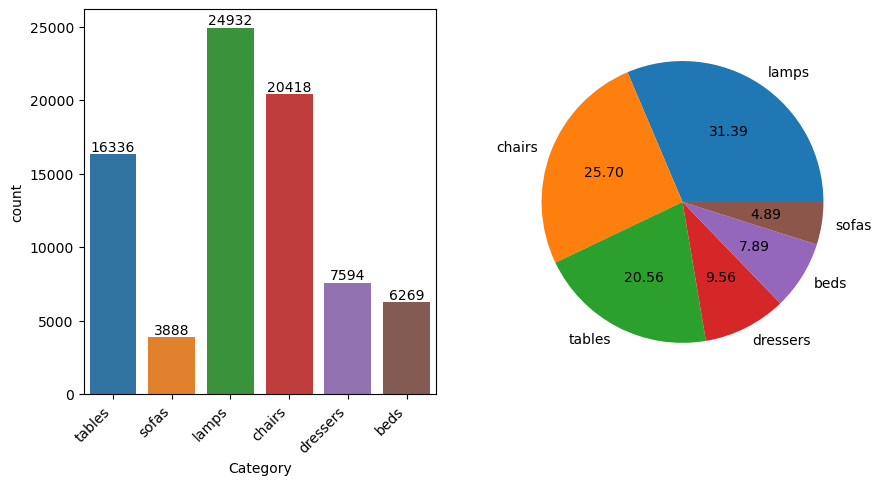

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax1 = sns.countplot(data=df, x='Category', ax=ax[0])
ax1.set_xticklabels(
    ax1.get_xticklabels(),
    rotation=45,
    ha="right"
)
for c in ax1.containers:
    ax1.bar_label(c)
    
ax2 = plt.subplot(1, 2, 2)
styles_count = df['Category'].value_counts()
ax2.pie(styles_count, labels=styles_count.index, autopct='%.2f')

plt.show()

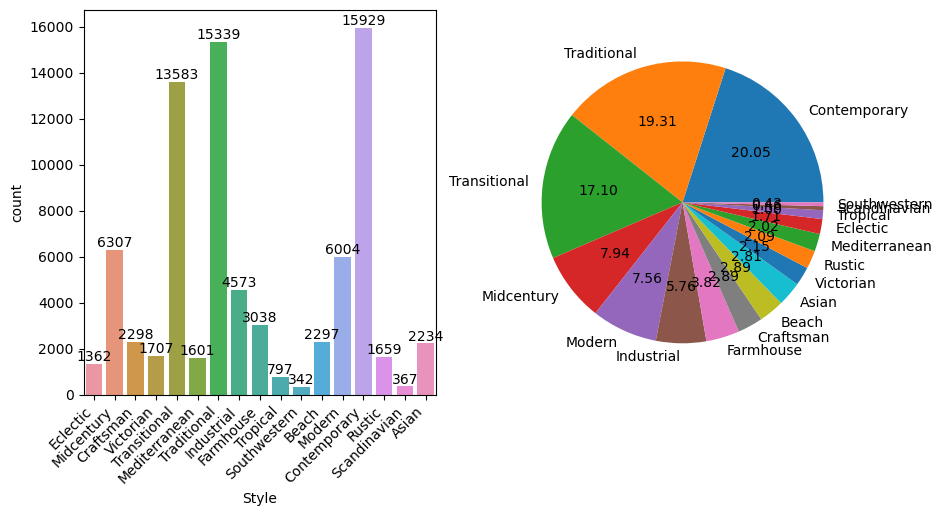

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax1 = sns.countplot(data=df, x='Style', ax=ax[0])
ax1.set_xticklabels(
    ax1.get_xticklabels(),
    rotation=45,
    ha="right"
)
for c in ax1.containers:
    ax1.bar_label(c)
    
ax2 = plt.subplot(1, 2, 2)
styles_count = df['Style'].value_counts()
ax2.pie(styles_count, labels=styles_count.index, autopct='%.2f')

plt.show()

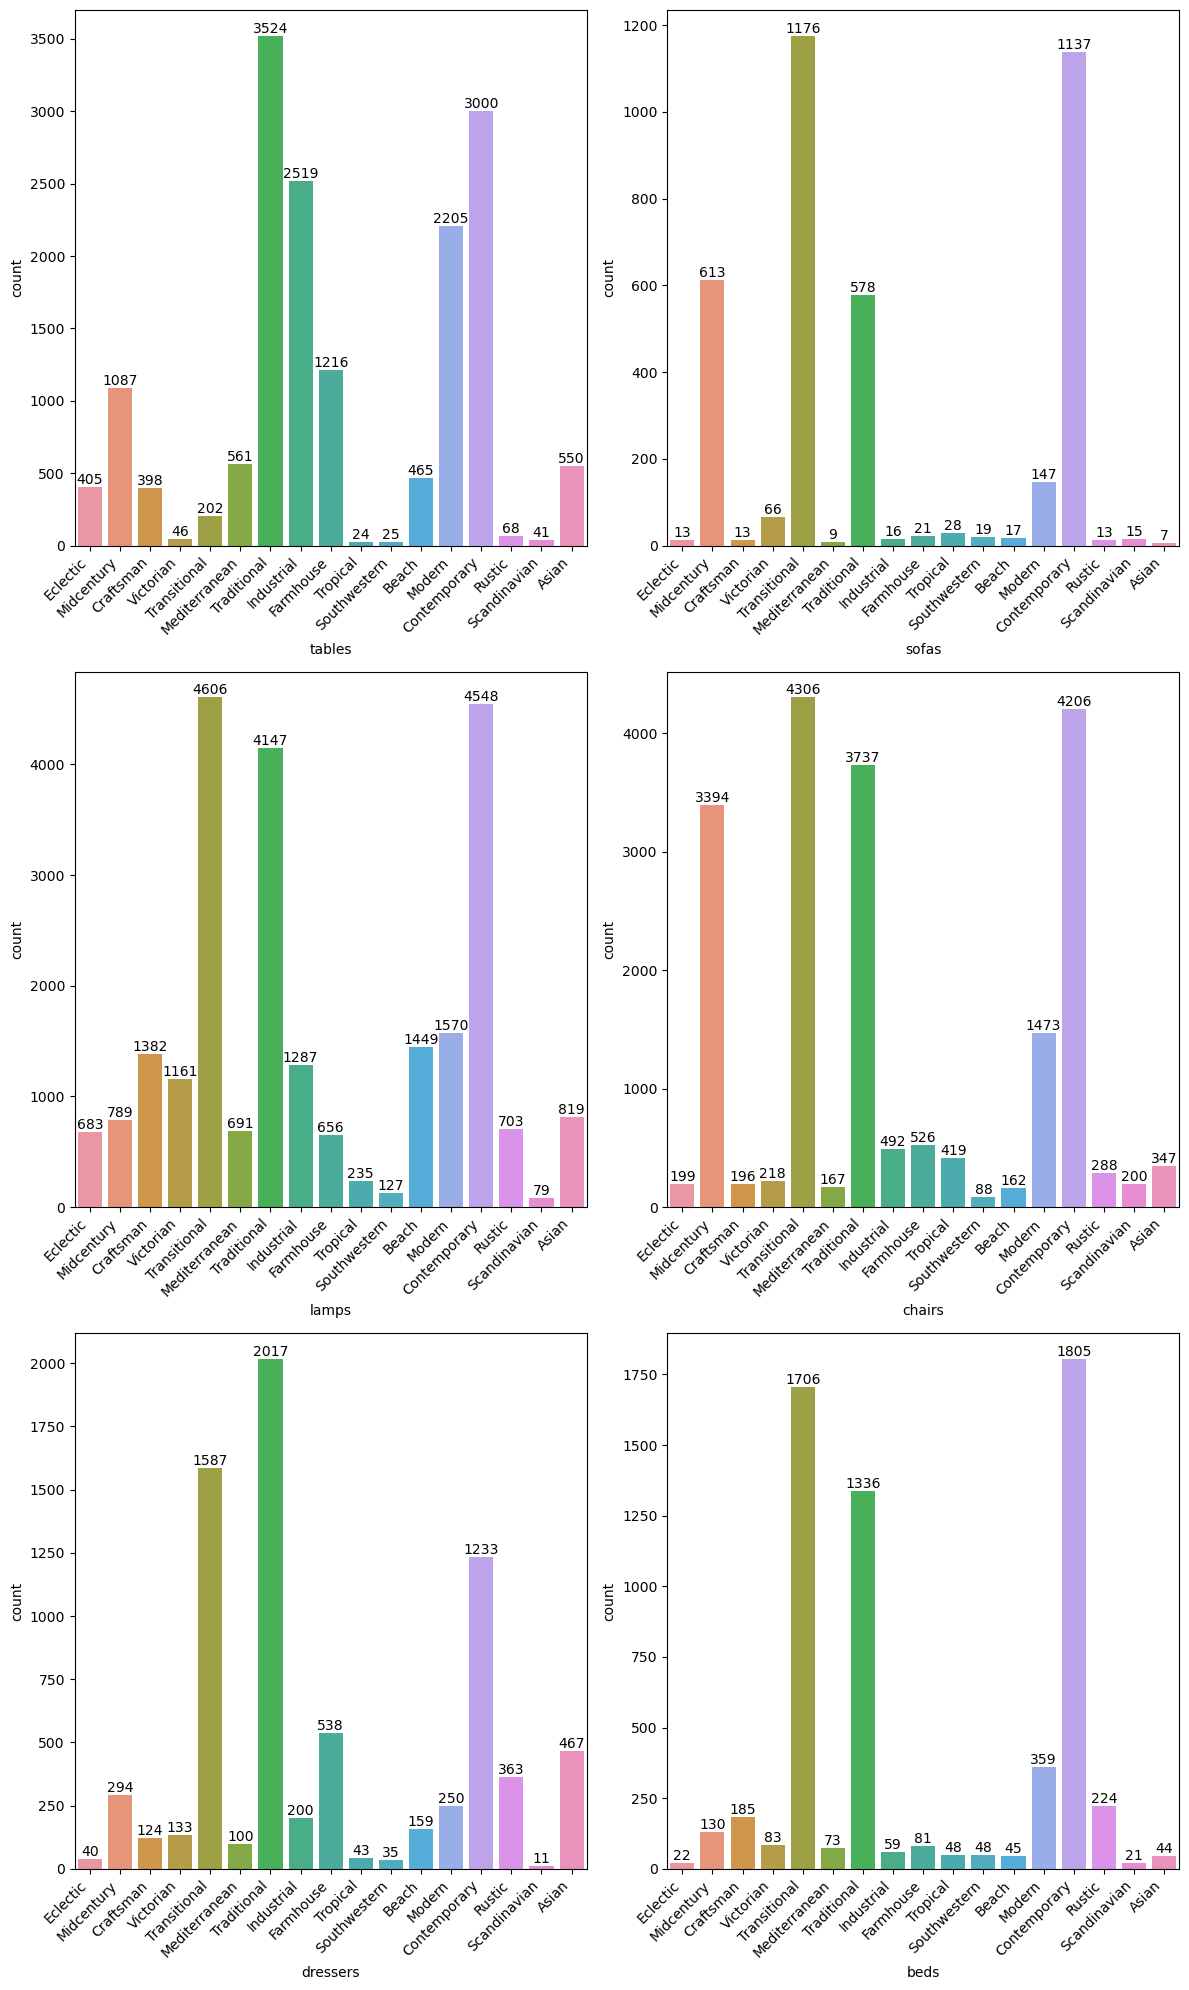

In [17]:
categories = df['Category'].unique()

fig, axs = plt.subplots(3, 2, figsize=(12, 20))
axs = axs.flatten()

for i, category in enumerate(categories):
    category_data = df[df['Category'] == category]
    
    row = i // 2
    col = i % 2
    
    ax = sns.countplot(data=category_data, x='Style', ax=axs[i])
    ax.set_xlabel(category)
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        ha="right"
    )
    for c in ax.containers:
        ax.bar_label(c)

plt.tight_layout()
plt.show()

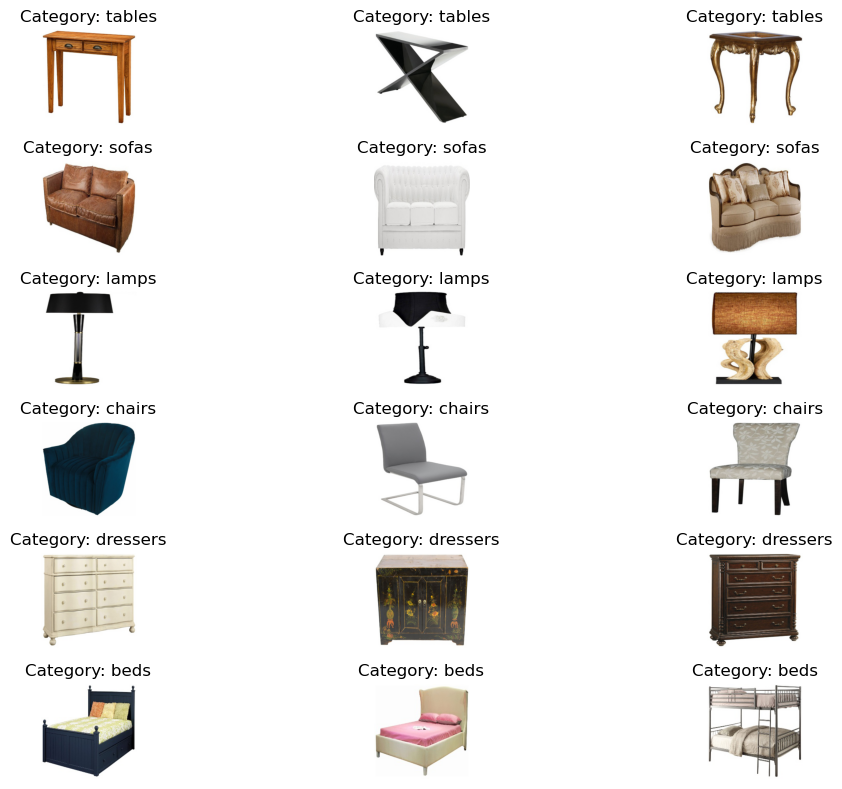

In [18]:
# Function to display sample images
def display_sample_images(df, num_images_per_category=3):
    unique_categories = df['Category'].unique()
    fig, axes = plt.subplots(len(unique_categories), num_images_per_category, figsize=(12, 8))

    for i, category in enumerate(unique_categories):
        category_images = df[df['Category'] == category]['Img'].sample(num_images_per_category, random_state=42)
        for j, (image, ax) in enumerate(zip(category_images, axes[i])):
            img = Image.open(image)
            ax.imshow(img)
            ax.set_title(f"Category: {category}")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Display sample images
display_sample_images(df)

## Model

In [75]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [76]:
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, shuffle=True, random_state=42)

In [77]:
# preprocessing input
train_generator = ImageDataGenerator(
    preprocessing_function=keras.applications.vgg19.preprocess_input
)

val_generator = ImageDataGenerator(
    preprocessing_function=keras.applications.vgg19.preprocess_input
)

test_generator = ImageDataGenerator(
    preprocessing_function=keras.applications.vgg19.preprocess_input
)

In [78]:
# split data into 3 sub-groups
BATCH_SIZE = 32
TARGET_SIZE = (256, 256)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col='Img',
    y_col='Category',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

val_images = val_generator.flow_from_dataframe(
    dataframe=val_data,
    x_col='Img',
    y_col='Category',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_data,
    x_col='Img',
    y_col='Category',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 54048 validated image filenames belonging to 6 classes.
Found 18017 validated image filenames belonging to 6 classes.
Found 18017 validated image filenames belonging to 6 classes.


### VGG-19

* Sample model: https://www.kaggle.com/code/vencerlanz09/corals-image-classification-using-vgg19
* Ref: https://keras.io/api/applications/vgg/

In [92]:
from tensorflow import keras
from keras import layers
from keras import Model
from keras.models import Sequential
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Dense, BatchNormalization, Activation, Flatten
from keras.optimizers import Adam
from keras.applications.vgg19 import VGG19
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#### Data augmentation can be used to overcome the class imbalance and overfitting problem specifically in medical imaging applications as data set is very less

In [89]:
augment = Sequential([
  layers.Resizing(256,256),
  layers.Rescaling(1./255),
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomContrast(0.1),
])

In [84]:
# Load the pretained model
pretrained_model = VGG19(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


In [93]:
model_path = '../Models/vgg19-model.weights.h5'
model_callback = ModelCheckpoint(model_path,
                                 save_weights_only=True,
                                 monitor="val_accuracy",
                                 save_best_only=True)

early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-10)

tensor_board = TensorBoard(log_dir='./logs')


## Train model

In [ ]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)


outputs = Dense(6, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=5,
    callbacks=[
        early_stopping,
        tensor_board,
        model_callback,
        reduce_lr
    ]
)

Epoch 1/5
 164/1689 ━━━━━━━━━━━━━━━━━━━━ 2:08:51 5s/step - accuracy: 0.5614 - loss: 1.3768